In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fpath = './Data/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = './submission_75955.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [3]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125


family_size = data.n_people.values
days_array = np.arange(N_DAYS, 0, -1)
choice_dict = data.loc[:, 'choice_0': 'choice_9'].T.to_dict()

choice_array_num = np.full((data.shape[0], N_DAYS + 1), -1)
for i, choice in enumerate(data.loc[:, 'choice_0': 'choice_9'].values):
    for d, day in enumerate(choice):
        choice_array_num[i, day] = d

        
penalties_array = np.array([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(family_size.max() + 1)
])

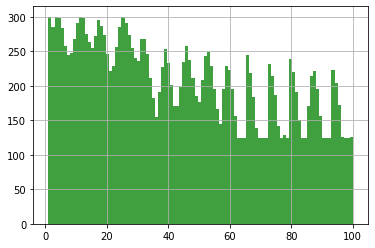

In [4]:
plt.hist(submission['assigned_day'], 100, density=False, facecolor='g', alpha=0.75, weights=family_size)
plt.grid()

plt.show()

In [5]:
# for n in range(2,9):
#     print("Famille de ", n)
#     lost = 0 
#     for r in range(10):
#         val = 0 
#         for i, row in data[data['n_people'] == n].iterrows():
            
#             if (submission['assigned_day'][i] in row[0:r].values):
#                 val += 1
#         if len(data[data['n_people'] == n]) - val != 0:
#             print(n, r,len(data[data['n_people'] == n]) - val, penalties_array[8, r]*(len(data[data['n_people'] == n]) - val))


In [6]:
def cost_function(prediction, penalties_array, family_size, days):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros((len(days)+1))
    N = family_size.shape[0]
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for i in range(N):
        # add the family member count to the daily occupancy
        n = family_size[i]
        d = prediction[i]
        choice = choice_array_num[i]
        
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        penalty += penalties_array[n, choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    relevant_occupancy = daily_occupancy[1:]
    incorrect_occupancy = np.any(
        (relevant_occupancy > MAX_OCCUPANCY) | 
        (relevant_occupancy < MIN_OCCUPANCY)
    )
    
    if incorrect_occupancy:
        penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = np.abs(today_count - yesterday_count)
        accounting_cost += max(0, (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0))
        yesterday_count = today_count

    

    return penalty,accounting_cost, penalty+accounting_cost

In [7]:
best = submission['assigned_day'].values
penalty, accounting, summ = cost_function(best, penalties_array, family_size, days_array)
print("penalty ", penalty)
print("accounting", accounting)

penalty  70747
accounting 5208.899044987306


<BarContainer object of 2 artists>

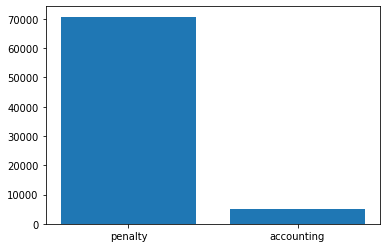

In [8]:
plt.bar([0, 1], [penalty, accounting], tick_label=["penalty", "accounting"])

In [9]:
# Generating permutation using Heap Algorithm 
def heapPermutation(a, size, n): 
      
    # if size becomes 1 then prints the obtained 
    # permutation 
    if (size == 1): 
        yield a
  
    for i in range(size): 
        yield from heapPermutation(a,size-1,n); 
  
        # if size is odd, swap first and last 
        # element 
        # else If size is even, swap ith and last element 
        if size&1: 
            a[0], a[size-1] = a[size-1],a[0] 
        else: 
            a[i], a[size-1] = a[size-1],a[i] 
          

In [10]:
NB_PERM = 3 
fam_active_choice = np.array([0,0,0])
fam_size = [2,8,3]
result = []

for x in range(10**NB_PERM):
    for i,x in enumerate(str(x).zfill(NB_PERM)):
        fam_active_choice[i] = int(x) 
    
    for p in heapPermutation(fam_active_choice.copy(), NB_PERM, NB_PERM):
        if  any([f == p for f, p in zip(fam_active_choice, p)]) :
            continue
        cost = 0
        for i in range(NB_PERM):
            cost += penalties_array[fam_size[i],fam_active_choice[i]] - penalties_array[fam_size[i],p[i]]
        result.append({"cost":cost,"p": p , "fam_active_choice" : fam_active_choice, "fam_size" : fam_size})
    


In [14]:
dt = pd.DataFrame(result)

dt["cost"].max()
val = 0 
for row in dt.iterrows():
    if row[1][0] > 0 :
       val += row[1][0]
print(val)


234432
